In [1]:
from ay_torch import *
%matplotlib widget

In [2]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=torchvision.transforms.ToTensor(),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=torchvision.transforms.ToTensor(),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_train[0] label value: 6 frog
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_test[0] label value: 3 cat


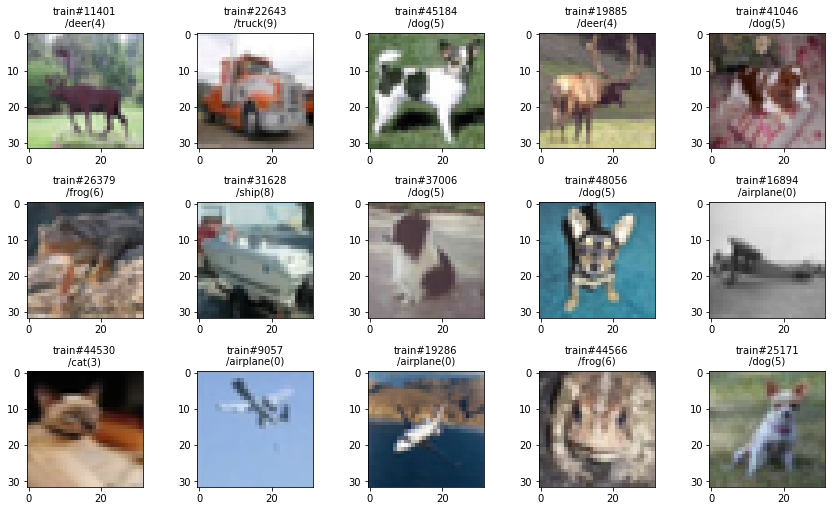

In [36]:
# fig= plt.figure(figsize=(12,7.2))
# rows,cols= 3,5
# for i in range(rows*cols):
#   i_data= np.random.choice(range(len(dset_train)))
#   img,label= dset_train[i_data]
#   #print(i_data,type(img),img.shape)
#   ax= fig.add_subplot(rows, cols, i+1)
#   ax.set_title('train#{0}/l={1}'.format(i_data,dset_train.classes[label]), fontsize=10)
#   ax.imshow(img.permute(1,2,0))
# fig.tight_layout()
# plt.show()

d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [5]:
class TAlexNet(torch.nn.Module):
  def __init__(self, n_classes):
    super(TAlexNet,self).__init__()
    self.net_features= torch.nn.Sequential(
          #torch.nn.Conv2d(in_channels, out_channels, ...)
          torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(kernel_size=2, stride=2),
          )
    self.classifier= torch.nn.Linear(256, n_classes)

  def forward(self, x):
    x= self.net_features(x)
    x= x.view(x.size(0), -1)
    return self.classifier(x)

In [48]:
#Setup a neural network.
net= net= TAlexNet(n_classes=len(dset_train.classes))

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


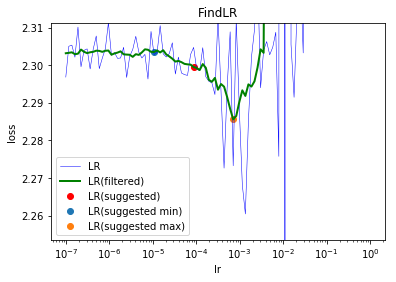

lr= 8.709635899560804e-05, lr_min=1.071519305237606e-05, lr_max=0.0007079457843841385


In [52]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
2.05607474	1.80086419	0.32852309	7.141980
1.66277343	1.50568936	0.45203025	7.175559
1.42751201	1.30741218	0.52259156	7.031259
1.28562479	1.23845550	0.55642914	7.001667
1.14849137	1.20891594	0.56876990	6.918368
1.02196648	1.08851611	0.62082006	6.851294
0.89026248	1.11782036	0.61673965	7.002362
0.75634745	1.09502818	0.63176752	7.278366
0.59415489	1.08235823	0.64998010	7.008466
0.42583687	1.24107223	0.63236465	7.178123
0.25571993	1.46839913	0.64908439	6.995609
0.12504584	1.74999202	0.65605096	6.882671
0.04876536	2.06219269	0.65555334	6.768053
0.02178066	2.25354421	0.65246815	6.814627
0.01483806	2.28180467	0.65416003	6.838672


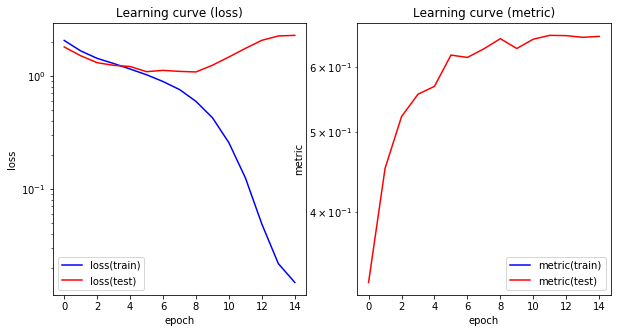

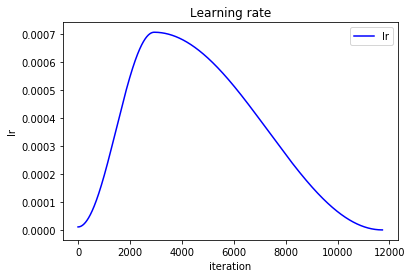

In [53]:
FitOneCycle(net, n_epoch=15, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

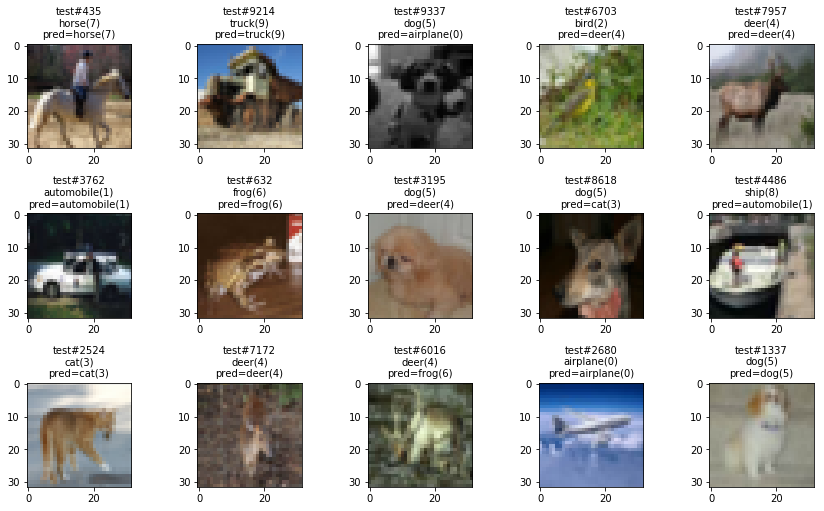

In [61]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)